In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2


/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


<Figure size 432x288 with 0 Axes>

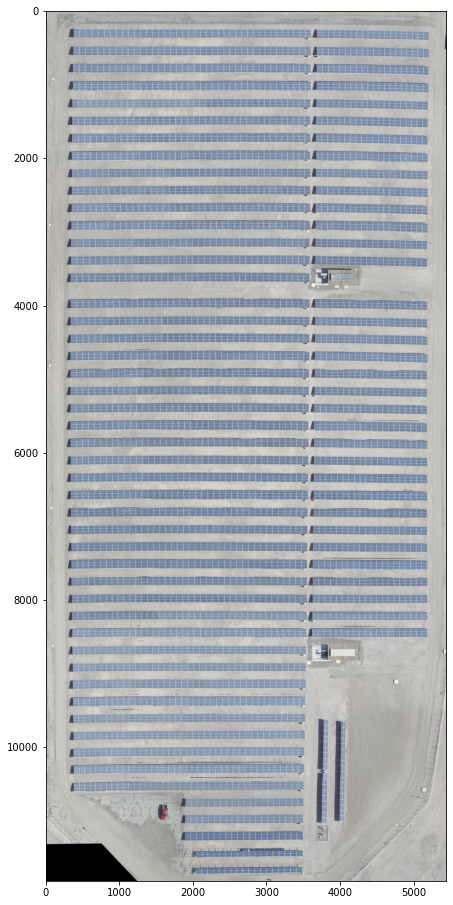

In [2]:
path_C = "El_Aguila/result_C.tif"

GR = gr.from_file(path_C)

plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0)))

HSV = Utils.rgb2hsv((GR.raster[:3,:,:]).transpose((1, 2, 0)))

H = HSV[:, :, 0]

<Figure size 432x288 with 0 Axes>

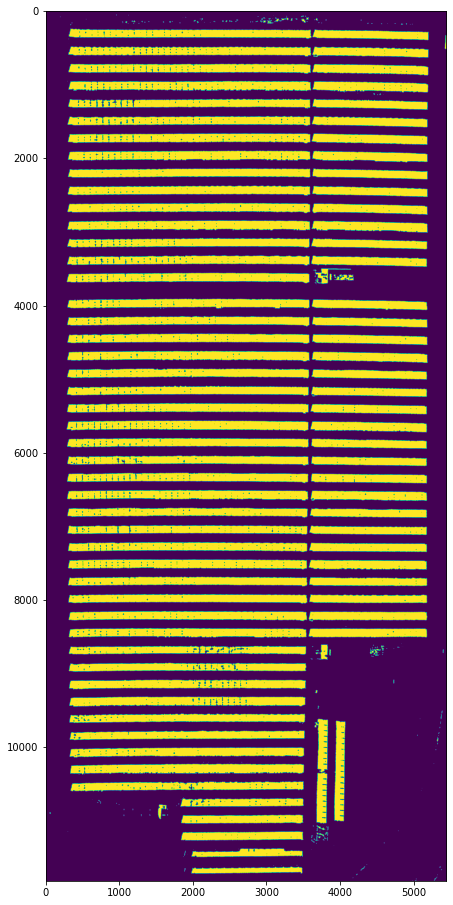

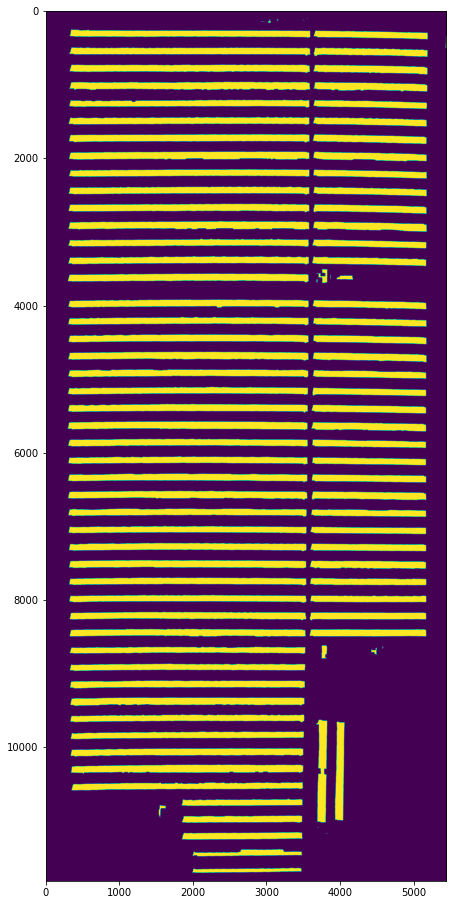

In [3]:
kernel_size = 21
edges = cv2.GaussianBlur((H).astype(np.uint8),(kernel_size, kernel_size),0)

H2 = np.ones(H.shape)
#H2 = cv2.GaussianBlur(H2,(9,9),0).astype('float32')
H2[edges > 270] = 0
#H2[H < 270] = 1
H2[edges < 210] = 0

kernel = np.ones((21, 21) , np.uint8)  # note this is a vertical kernel
closing_H2 = cv2.morphologyEx(H2.astype(float), cv2.MORPH_CLOSE, kernel)
erode_H2 = cv2.morphologyEx(closing_H2.astype(float), cv2.MORPH_ERODE, kernel)




plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(H2)

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(erode_H2)

<Figure size 432x288 with 0 Axes>

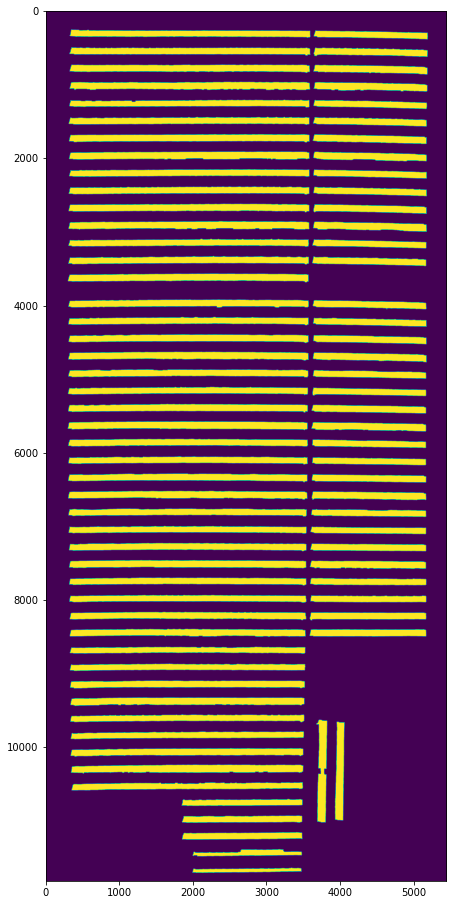

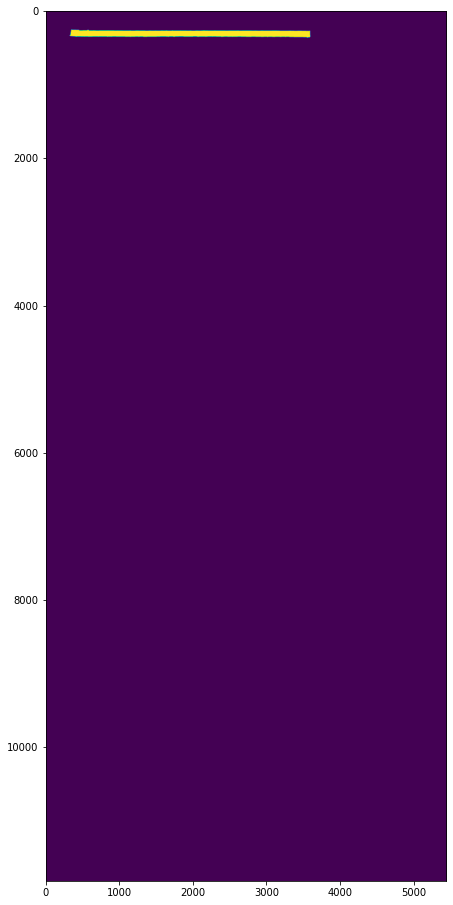

In [87]:

label_im, nb_labels = ndimage.label(erode_H2)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]

min_area = 50000
L = np.zeros(label_im.shape)

for i in range(nb_labels):
    if label_areas[i] > min_area:
        L[label_im == (i + 1) ] = 1
        
        
label_im, nb_labels = ndimage.label(L)#, structure= np.ones((2,2))) ## Label each connect region
label_areas = np.bincount(label_im.ravel())[1:]


plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow(L)

plt.figure(1)
plt.figure(figsize=(16, 16))
plt.imshow(label_im==1)
        

<Figure size 432x288 with 0 Axes>

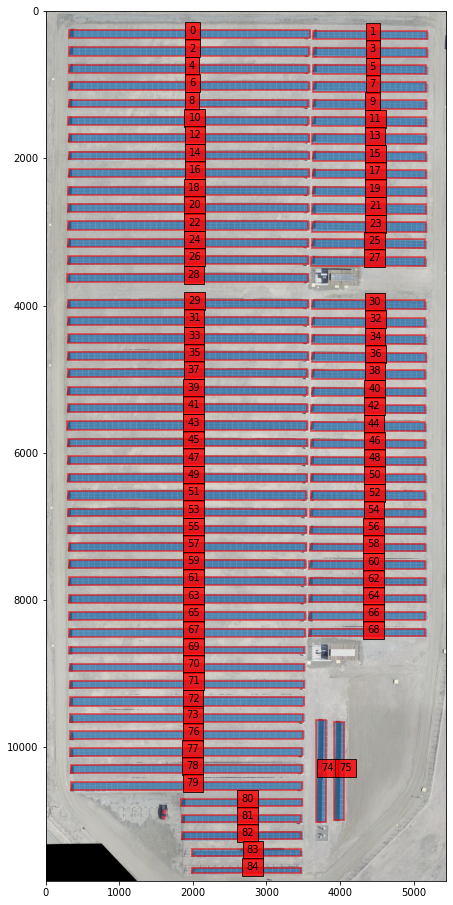

In [88]:
L_P = []
for i in range(1, nb_labels + 1):
    
    countours, hierarchy = cv2.findContours(np.uint8(label_im == i), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    x_max = np.max(countours[0][:, 0, 0])
    y_max = np.max(countours[0][:, 0, 1])
    x_min = np.min(countours[0][:, 0, 0])
    y_min = np.min(countours[0][:, 0, 1])
    
    List_P = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    L_P.append(List_P.copy())
    
L_P = np.stack(L_P, axis=0)



plt.figure(0)
plt.figure(figsize=(16, 16))
plt.imshow((GR.raster[:3,:,:]).transpose((1, 2, 0)))

ax = plt.gca()

for i,Poly in enumerate(L_P):
    poly = patches.Polygon(Poly,
                     linewidth=2,
                     edgecolor='red',
                     alpha=0.5,
                     fill = True)
    plt.text(np.mean([x[0]  for x in Poly]), np.mean([y[1]  for y in Poly]) , str(i),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)